In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from IPython.display import display, HTML

sns.set(palette="bright", style="whitegrid")

In [3]:
df = pd.read_csv("results.tsv", sep="\t")

In [16]:
[s.replace("_", " ") for s in df.columns]

['binary',
 'branchless cmov',
 'branchless sub',
 'branchless sub fix',
 'linear scan',
 'linear scan cmov',
 'linear scan sub',
 'templated cmov']

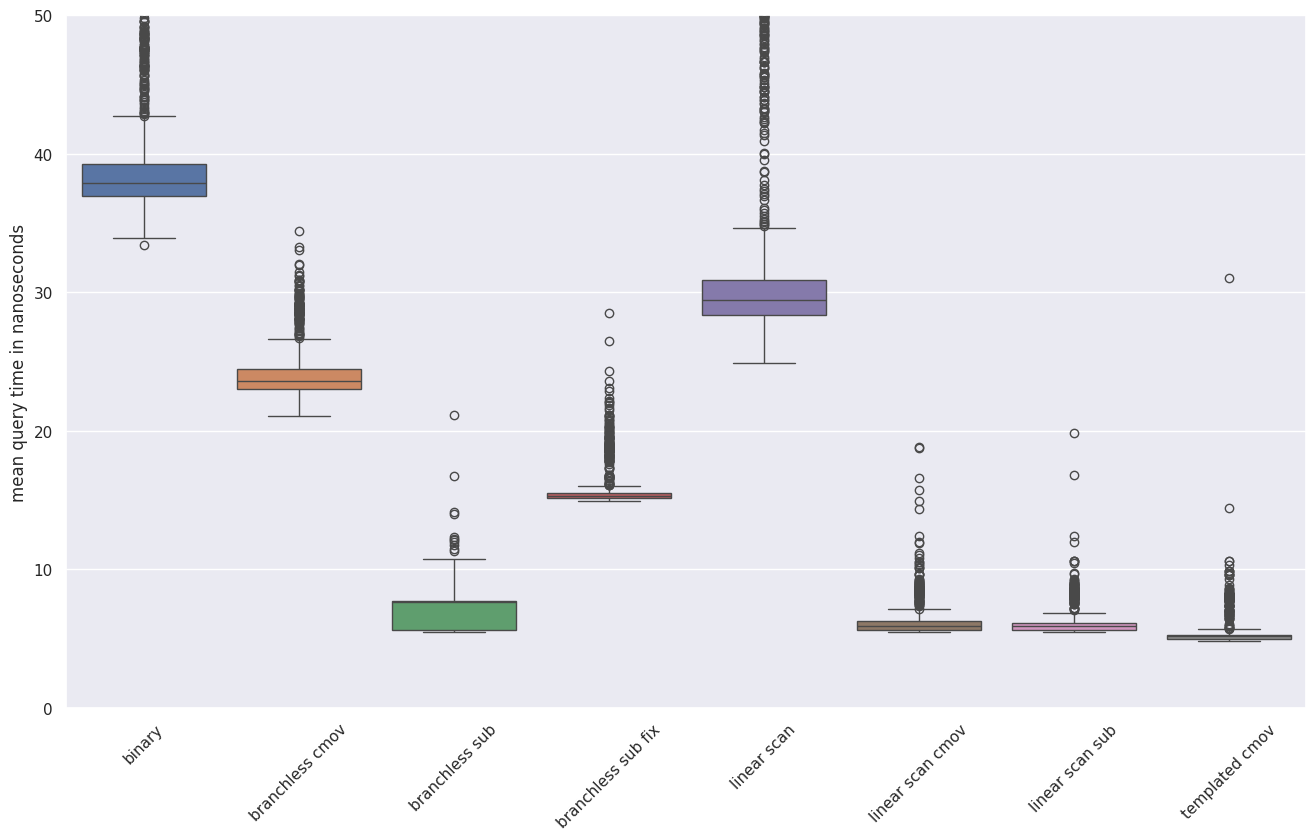

In [37]:
plt.figure(figsize=(16, 9))
sns.boxplot(data=df)
plt.ylim((0, 50))
plt.xticks(ticks=[i for i in range(len(df.columns))], labels=[s.replace("_", " ") for s in df.columns], rotation=45)
plt.ylabel("mean query time in nanoseconds")
plt.savefig("results.png", bbox_inches="tight")
plt.show()

In [28]:
perf_df = pd.read_csv("perf.tsv", sep="\t", index_col=8)

In [35]:
print(perf_df.to_html())

<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>binary</th>
      <th>branchless_cmov</th>
      <th>branchless_sub</th>
      <th>branchless_sub_fix</th>
      <th>linear_scan</th>
      <th>linear_scan_cmov</th>
      <th>linear_scan_sub</th>
      <th>templated_cmov</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Cycles per search</th>
      <td>75.892100</td>
      <td>42.741000</td>
      <td>12.07410</td>
      <td>29.29800</td>
      <td>54.60020</td>
      <td>11.77600</td>
      <td>10.98410</td>
      <td>10.15770</td>
    </tr>
    <tr>
      <th>Instructions per search</th>
      <td>74.380000</td>
      <td>36.327800</td>
      <td>46.31000</td>
      <td>102.33000</td>
      <td>167.86900</td>
      <td>53.42000</td>
      <td>52.33000</td>
      <td>43.41000</td>
    </tr>
    <tr>
      <th>Banch misspredictions per search</th>
      <td>3.752340</td>
      <td>2.500940</td>
      <td>0.01061</td>
     

In [43]:
reg = re.compile(r"BM_([^\d]*)(\d+)")
cols = ["Benchmark", "time (ns)", "u1", "cpu (ns)", "u2", "Iterations", "checksum"]
df = pd.read_csv("AMD_EPYC_7452.res", sep=r"\s+", skiprows=3, names=cols, index_col=0)
df.drop(columns=["u1", "u2"], inplace=True)
typ, size = zip(*[reg.match(u).groups() for u in df.index])
df["Type"] = typ
df["Size"] = [int(s) for s in size]
df["time (ns)"] = df["time (ns)"] / 100000
df["cpu (ns)"] = df["cpu (ns)"] / 100000

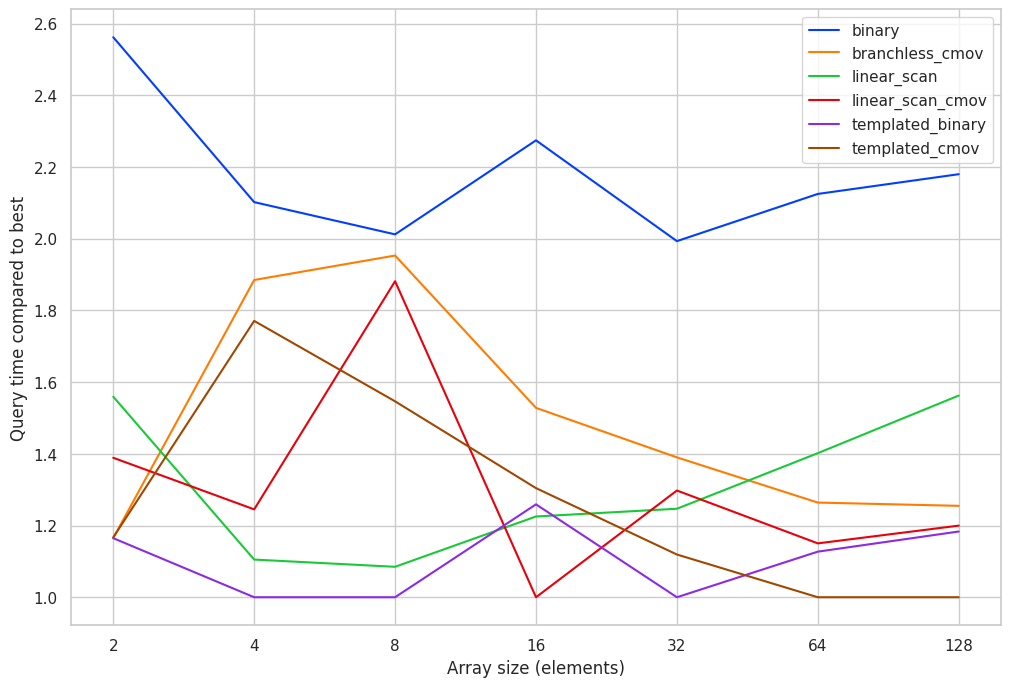

In [44]:
plt.figure(figsize=(12, 8))
mins = np.asarray([
    np.min(g[1]["time (ns)"])
    for g in df.groupby("Size")
])
for g in df.groupby("Type"):
    if "sub" in g[0]:
        continue
    y = g[1]["time (ns)"] / mins
    plt.plot(g[1]["Size"], y, label=g[0])
plt.ylabel("Query time compared to best")
plt.xlabel("Array size (elements)")
plt.xscale("log")
ticks = sorted(np.unique(df["Size"]))
plt.xticks(ticks=ticks, labels=ticks)
plt.legend()
plt.show()

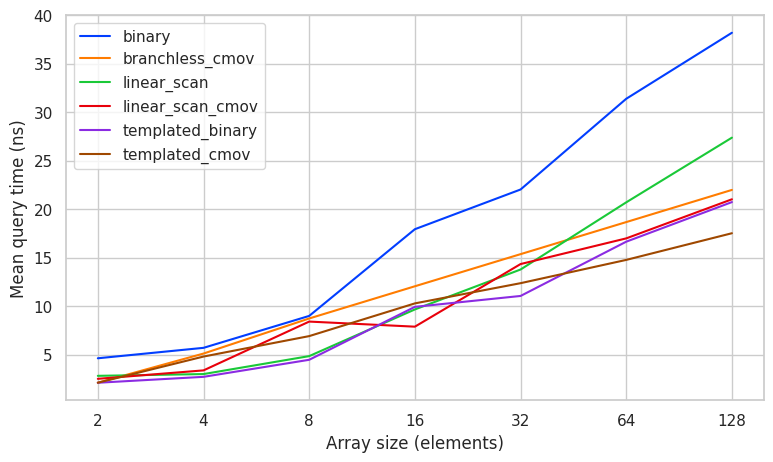

In [46]:
plt.figure(figsize=(9, 5))
for g in df.groupby("Type"):
    if "sub" in g[0]:
        continue
    y = g[1]["time (ns)"]
    plt.plot(g[1]["Size"], y, label=g[0])
plt.ylabel("Mean query time (ns)")
plt.xlabel("Array size (elements)")
plt.xscale("log")
ticks = sorted(np.unique(df["Size"]))
plt.xticks(ticks=ticks, labels=ticks)
plt.legend()
plt.show()

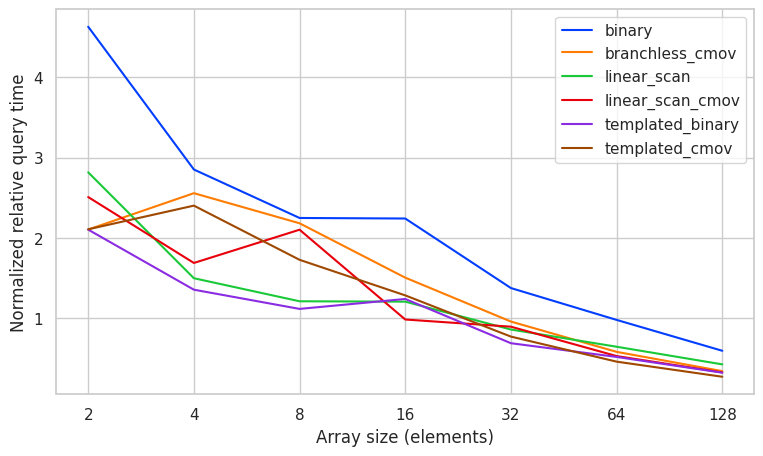

In [48]:
plt.figure(figsize=(9, 5))
for g in df.groupby("Type"):
    if "sub" in g[0]:
        continue
    y = g[1]["time (ns)"] * 2 / g[1]["Size"]
    plt.plot(g[1]["Size"], y, label=g[0])
plt.ylabel("Normalized relative query time")
plt.xlabel("Array size (elements)")
plt.xscale("log")
ticks = sorted(np.unique(df["Size"]))
plt.xticks(ticks=ticks, labels=ticks)
plt.legend()
plt.show()